<a href="https://colab.research.google.com/github/namoshi/colab/blob/master/%5Bpublished%5D_Keras_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VAE implementation demo

## Define the encoder

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

In [ ]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 7, 7, 64)     18496       conv2d_3[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 3136)         0           conv2d_4[0][0]                   
____________________________________________________________________________________________

## Define the sampling function

In [ ]:
class Sampler(layers.Layer):
    def call(self, z_mean, z_log_var):
        batch_size, z_size = tf.shape(z_mean)[0], tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch_size, z_size))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Define the decoder

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [ ]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

## Define the training loop

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        self.total_loss_tracker = keras.metrics.Mean(name='total_loss')
        self.ae_loss_tracker = keras.metrics.Mean(name='ae_loss')
        self.kl_loss_tracker = keras.metrics.Mean(name='kl_loss')

    @property
    def metrics(self):
      return [self.total_loss_tracker, self.ae_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampler(z_mean, z_log_var)
            reconstruction = decoder(z)
            ae_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = ae_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.ae_loss_tracker.update_state(ae_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "total_loss": self.total_loss_tracker.result(),
            "ae_loss": self.ae_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

## Train the model on MNIST data

In [ ]:
import numpy as np

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 4s 7ms/step - total_loss: 212.4849 - ae_loss: 210.1652 - kl_loss: 2.3196
Epoch 2/30
547/547 [==============================] - 4s 7ms/step - total_loss: 180.8012 - ae_loss: 176.2507 - kl_loss: 4.5506
Epoch 3/30
547/547 [==============================] - 4s 7ms/step - total_loss: 166.2829 - ae_loss: 160.5332 - kl_loss: 5.7497
Epoch 4/30
547/547 [==============================] - 4s 7ms/step - total_loss: 161.6676 - ae_loss: 155.6246 - kl_loss: 6.0430
Epoch 5/30
547/547 [==============================] - 4s 7ms/step - total_loss: 159.1120 - ae_loss: 152.9099 - kl_loss: 6.2022
Epoch 6/30
547/547 [==============================] - 4s 7ms/step - total_loss: 157.4720 - ae_loss: 151.1945 - kl_loss: 6.2775
Epoch 7/30
547/547 [==============================] - 4s 7ms/step - total_loss: 156.3650 - ae_loss: 150.0419 - kl_loss: 6.3231
Epoch 8/30
547/547 [==============================] - 4s 7ms/step - total_loss: 155.2730 - ae_loss: 148.9061 - 

## Display grid of images sampled from the latent space

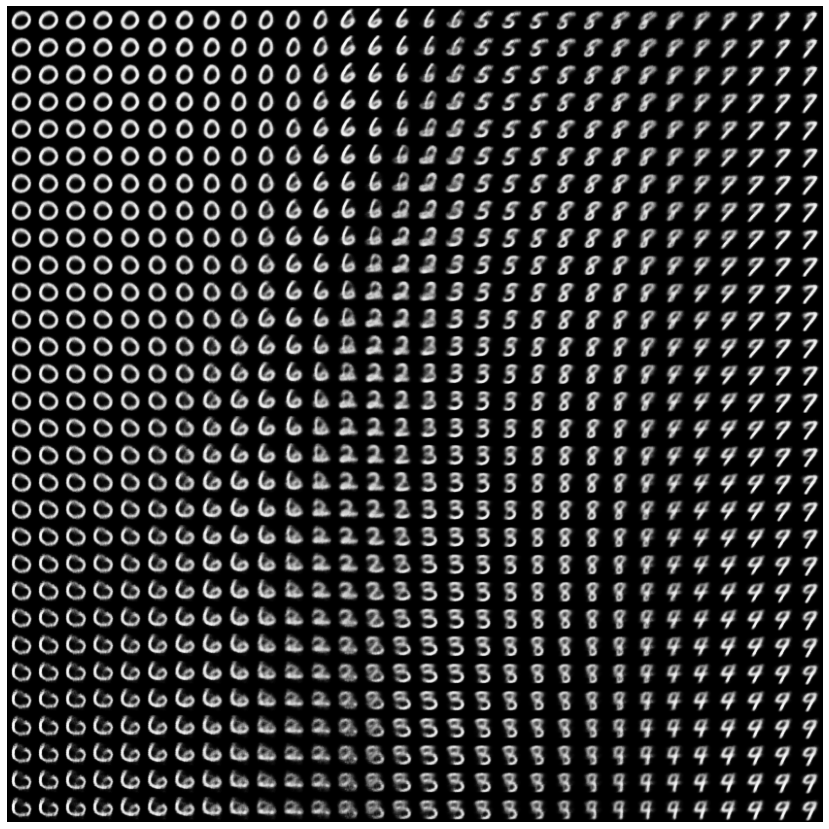

In [ ]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=30, figsize=15):
    # Display a n*n 2D manifold of digits.
    digit_size = 28
    scale = 1
    figure = np.zeros((digit_size * n, digit_size * n))
    # Linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space.
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.axis("off")
    plt.imshow(figure, cmap="Greys_r")
    plt.savefig('vae_grid.png', dpi=300)


plot_latent_space(vae)